# 餐飲業逾期風險預測模型
由我國「應建立食品追溯追蹤系統之食品業者」規定可知，須申報食品流向資料於本署非追不可系統多為製造與輸入業者，對於販售與餐飲業者則無相關資料可用，無法推算其庫存，進而評估其是否可能存放逾期食品。因此，針對販售與餐飲業者，則透過後市場稽查資料及業者相關資訊，嘗試以監督式學習方法建構業者逾期食品違規風險預測模型，而此處為餐飲業資料的建模評估。

### 程式架構
* 資料前處理(Preprocessing.ipynb)
* **特徵篩選(ModelFitting.ipynb)**
* 模型配適(FeatureSelection.ipynb)

## 特徵篩選

### Package

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder    # 特徵縮放、編碼，為計算其變異數
from sklearn.compose import make_column_transformer    # 建立流程
from sklearn.feature_selection import VarianceThreshold    # 移除低變異特徵

### Data Import

In [3]:
dict_df_pre = pd.read_pickle('../data/data_pre.pkl')
dict_df_pre.keys()

dict_keys(['others', 'train', 'test'])

In [4]:
X_train = dict_df_pre['train']['X']

### Data Visualize

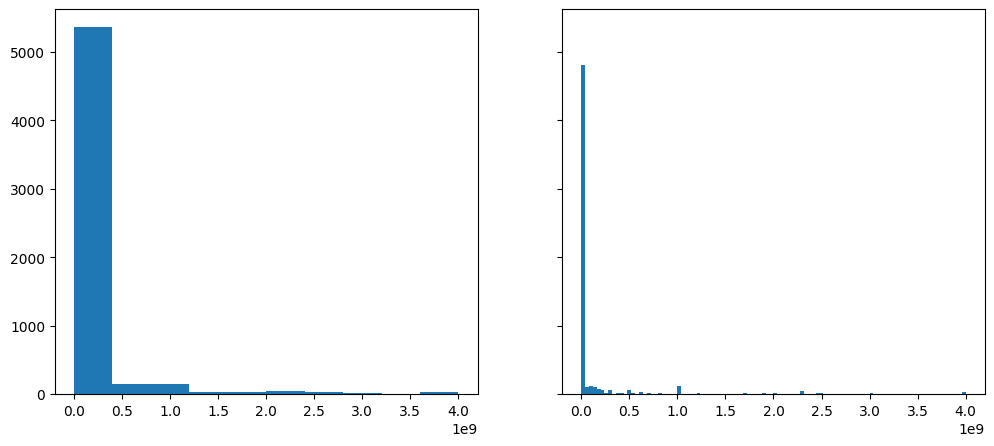

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)

axs[0].hist(x=X_train['資本額'])
axs[1].hist(x=X_train['資本額'], bins = 100)
plt.show()

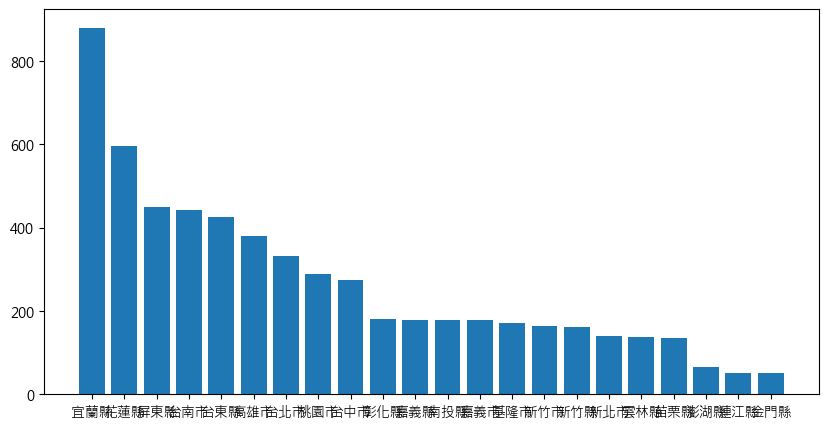

In [5]:
count_cat = X_train['營業縣市'].value_counts()

plt.rcParams['font.family'] = 'Microsoft JhengHei'
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x=count_cat.index, height=count_cat.values)

plt.show()


### Remove Low-variance Features by Variance Threshold

* 特徵編碼

In [4]:
# 各編碼所使用特徵名稱
cols_to_DumEnc = [col for col in X_train.select_dtypes(include='category').columns if not X_train[col].dtype.ordered]
cols_to_OrdEnc = [col for col in X_train.select_dtypes(include='category').columns if X_train[col].dtype.ordered]

# 編碼流程
enc_trans = make_column_transformer(
    (OneHotEncoder(drop='first', dtype='uint8', sparse_output=False), cols_to_DumEnc),    # dummy encoding
    (OrdinalEncoder(dtype='uint8'), cols_to_OrdEnc),    # uint8: 0 to (2**8)-1 (recommend)
    remainder='passthrough',    # 略過剩餘欄位
    force_int_remainder_cols=False,    # corresponds to the `remainder` (default: True)
    verbose_feature_names_out=False    # 去掉 transformer 前綴
).set_output(transform='pandas')    #輸出 dataframe

enc_trans.fit(X_train)    # fit
X_enc = enc_trans.transform(X_train)    # transform

* 特徵縮放

In [5]:
# 縮放特徵名稱
cols_to_scale = list(X_enc.select_dtypes(include='uint32').columns) + cols_to_OrdEnc

# 建立 MinMaxScaler 物件
mms = MinMaxScaler(feature_range=(0, 1)).set_output(transform='pandas')    # feature_range=(0, 1) (default)

# 執行特徵縮放
X_scale = mms.fit_transform(X_enc[cols_to_scale]).astype('float32')

X_vt0 = pd.concat([X_scale, X_enc.drop(cols_to_scale, axis=1)], axis=1)

In [6]:
del X_train, cols_to_DumEnc, cols_to_OrdEnc, mms, X_scale

* 特徵篩選

In [7]:
# 以查獲逾期食品案件比例作為特徵篩選門檻
t = dict_df_pre['train']['y'].mean()

# 建立（初始化） VarianceThreshold 物件：物件名稱 = 類別名稱()
vt = VarianceThreshold(threshold=t).set_output(transform='pandas')    # default 0.0

# 執行篩選
X_vt = vt.fit_transform(X_vt0)

In [15]:
print(f'variance threshold: {t:.4f}')

# 特徵篩選及 variance 計算結果
df_vtRsl = pd.DataFrame(
    data = {
        '特徵': list(X_vt0.columns), 
        '變異數': list(np.var(X_vt0, axis=0).round(decimals=4)), 
        '是否排除': [False if c in X_vt.columns else True for c in X_vt0.columns]
    }, 
)

variance threshold: 0.0053


* 縮放特徵轉回原始特徵（SMOTE -> Standardization）

In [16]:
X_train_select = pd.concat([X_enc[cols_to_scale], X_vt.drop(cols_to_scale, axis=1, errors='ignore')], axis=1)

In [17]:
del cols_to_scale, X_enc, X_vt0, vt, X_vt

* 測試集做特徵編碼與篩選

In [18]:
X_test = dict_df_pre['test']['X']

# 套用訓練集執行內容
cols_drop = df_vtRsl[df_vtRsl['是否排除']]['特徵'].values
X_test_select = enc_trans.transform(X_test).drop(cols_drop, axis=1)

In [19]:
del enc_trans, cols_drop, X_test

### Data Save

In [20]:
dict_df_pre['train']['X_select'] = X_train_select
dict_df_pre['test']['X_select'] = X_test_select
dict_vt = {'vt': t, 'result': df_vtRsl}
dict_df_pre['feature_selection'] = dict_vt

pd.to_pickle(dict_df_pre, 'data_fs.pkl')